# Markov Random Fields
## An image de-noising example: Ising Model

A random markov field probabilistic model represented as a nondirected graph such that can be written as

$$
    p({\bf x}) = \frac{1}{Z} \prod_c\psi_c({\bf x}_c)
$$

Where $Z = \sum_{\bf x}\prod_c \psi_c({\bf x}_c)$, and the product runs over the *maximal* cliques in the graph.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from skimage.io import imread
from numpy.random import seed, random
from sklearn.metrics import confusion_matrix

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
img = imread("img.jpeg", as_gray=True)
img_shape = img.shape
img = np.round(img)
img.shape

(576, 598)

Let $\{y_i\}_i$ be the pixels of an observed noisy image. We suppose that the noisy image was generated using a noise-free image with pixels $\{x_i\}_i$ and randomly flippning the signs of the pixel with some small probability

In [4]:
final_noisy = np.copy(img)
# p(flip) = 0.1
mmap = random(size=(img_shape)) <= 0.2
final_noisy[mmap] = np.abs(final_noisy[mmap] - 1)

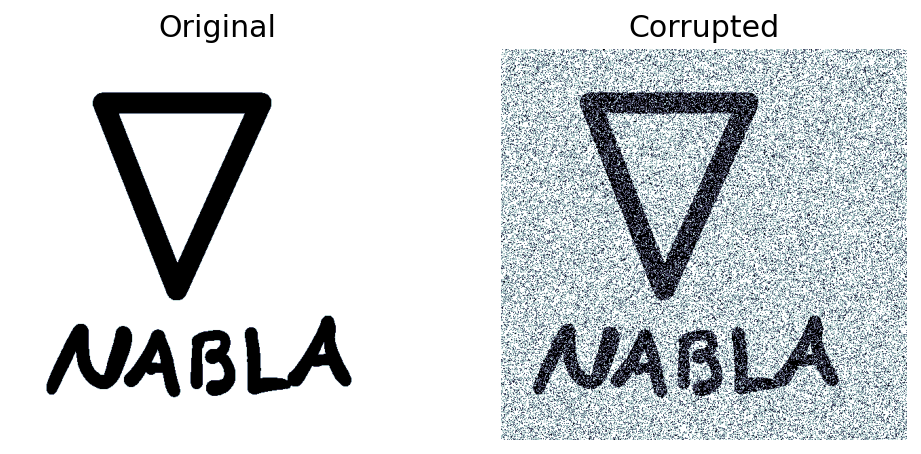

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(img, cmap="bone")
ax[1].imshow(final_noisy, cmap="bone")
ax[0].set_title("Original", fontsize=15)
ax[1].set_title("Corrupted", fontsize=15)
ax[0].axis("off")
ax[1].axis("off");

Our energy function is given by
$$
    E({\bf x}, {\bf y}) = h\sum_ix_i - \beta \sum_{\{i,j\}}x_ix_j - \eta\sum_ix_iy_i 
$$

For `jit` (just-in-time)
```
@jit
````
See e.g. https://ipython-books.github.io/52-accelerating-pure-python-code-with-numba-and-just-in-time-compilation/

In [6]:
@jit(nopython=True)
def find_neighbors(x, i, j):
    """
    Find neighboring indices
    """
    nx, ny = x.shape
    rows, cols = [], []
    if i > 0:
        rows.append(i - 1)
        cols.append(j)
    if j > 0:
        rows.append(i)
        cols.append(j - 1)
    if i < nx - 1:
        rows.append(i + 1)
        cols.append(j)
    if j < ny - 1:
        rows.append(i)
        cols.append(j + 1)
        
    return rows, cols


@jit(nopython=True)
def E(x, y, h=0, beta=1.0, eta=2.1):
    total_energy = h * x.sum() - eta * (x * y).sum()
    total_energy = 0
    nx, ny = x.shape
    for i in range(nx):
        for j in range(ny):
            
            rows, cols = find_neighbors(x, i, j)
                
            neighbor_energy = 0.
            for row, col in zip(rows, cols):
                neighbor_energy = neighbor_energy + x[row, col] * x[i, j]
            
            total_energy = total_energy - beta * neighbor_energy - eta * x[i, j] * y[i, j]
            
    return total_energy


@jit(nopython=True)
def neighbor_energy(x, i, j, beta):
    """
    Sum of energies in the neighborhood
    """
    rows, cols = find_neighbors(x, i, j)
    energy = 0.
    for row, col in zip(rows, cols):
        energy = energy + x[row, col]
    return x[i,j] * beta * energy


@jit(nopython=True)
def local_energy(x, y, i, j, h=0, beta=1.0, eta=2.1):
    """
    Helper function to reach a field with lower energy. It
    makes use of the fact that changing the sign of a node
    affects only the cliques around it.
    """
    rows, cols = find_neighbors(x, i, j)
    neigh_energy = neighbor_energy(x, i, j, beta)
    # Energy from neighbors in xy-clique
    neigh_xy_energy = 0.0
    for row, col in zip(rows, cols):
        neigh_energy += neighbor_energy(x, row, col, beta)
        neigh_xy_energy += eta * x[row, col] * y[row, col] 
    energy = h * x[i, j] - eta * x[i, j] * y[i, j] - neigh_energy - neigh_xy_energy
    return energy


@jit(nopython=True)
def update_pixels(x, y):
    nx, ny = x.shape
    x = x.copy()
    for i in range(nx):
        for j in range(ny):
            x[i,j] = 1
            energy_plus = local_energy(x, y, i, j)
            
            x[i,j] = -1
            energy_minus = local_energy(x, y, i, j)
                
            # Go to the state with lower energy
            if energy_plus <= energy_minus:
                x[i,j] = 1
            else:
                x[i,j] = -1
                
    return x


@jit(nopython=True)
def ising_learn(y):
    x = y.copy()

    E_hist = [E(x, y)]
    while True:
        x = update_pixels(x, y)
        E_hist.append(E(x, y))
        if E_hist[-1] / E_hist[-2] - 1 < 1e-6:
            break
    return E_hist, x

In [7]:
%%time
y = final_noisy.copy() * 2 - 1
E_hist, x = ising_learn(y)

CPU times: user 1min 1s, sys: 920 ms, total: 1min 2s
Wall time: 1min 57s


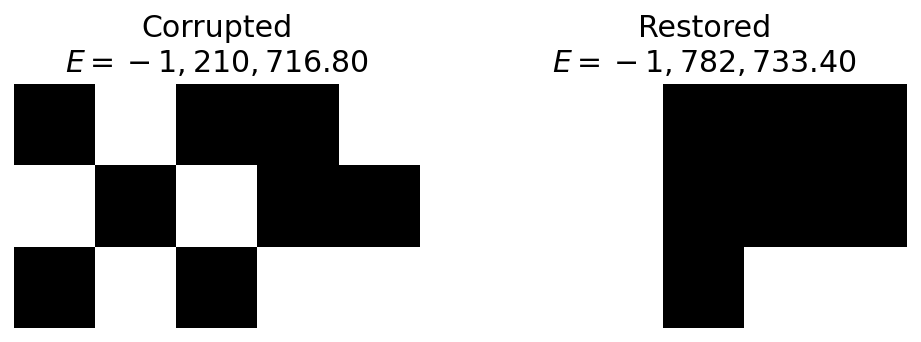

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(y, cmap="bone")
ax[1].imshow(x, cmap="bone")
ax[0].set_title(f"Corrupted\n$E={E_hist[0]:,.2f}$", fontsize=15)
ax[1].set_title(f"Restored\n$E={E_hist[-1]:,.2f}$", fontsize=15)
ax[0].axis("off")
ax[1].axis("off");

In [16]:
# Optimal energy state
format(E(img * 2 - 1, y), ",.2f")

ValueError: unable to broadcast argument 1 to output array
File "<ipython-input-6-cbd6a6a1fc1c>", line 26, 

In [10]:
confusion_matrix((img * 2 - 1).ravel(), x.ravel())

array([[ 44211,   1096],
       [  3230, 295911]])

## A Smaller Example

In [11]:
y = np.array([
    [0, 1, 0, 0, 1],
    [1, 0, 1, 0, 0],
    [0, 1, 0, 1, 1]
])

y = 2 * y - 1

def show_grid(x):
    plt.pcolor(x[::-1], cmap="bone_r", linewidths=3, edgecolors="tab:gray")
    plt.xticks([])
    plt.yticks([])

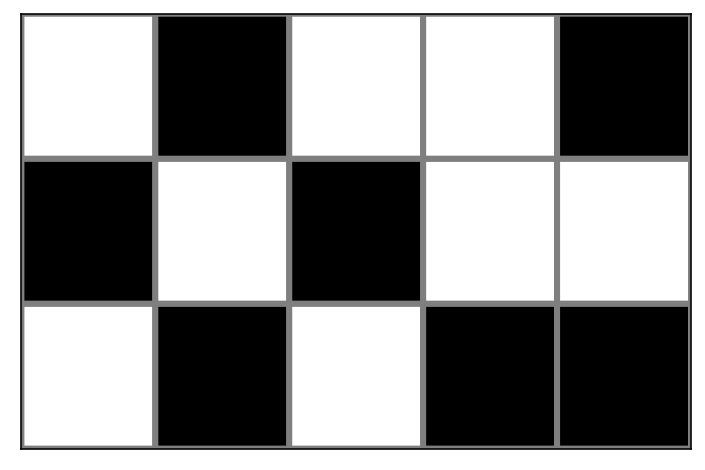

In [12]:
show_grid(y)

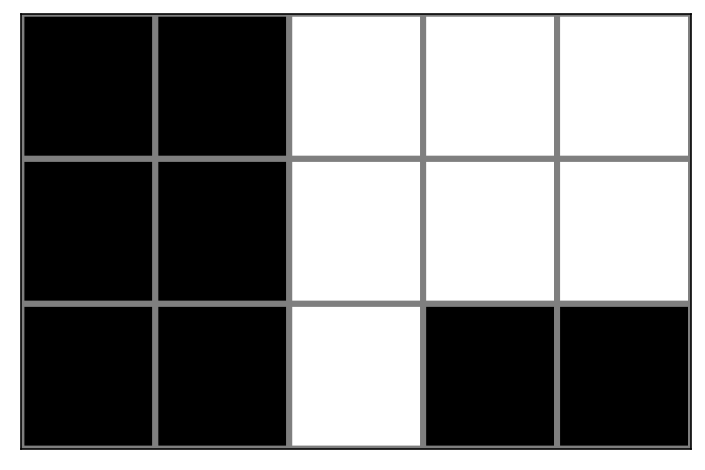

In [13]:
_, x = ising_learn(y)
show_grid(x)

In [14]:
print(E(y, y))
print(E(x, y))

-3.5000000000000013
-30.500000000000007
